# Explore Exercises

Remember to document your thoughts and any takeaways as you work through visualizations!

Using your store items data you prepped in lesson 2 exercises

In [210]:
import prepare
import acquire
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import TimeSeriesSplit

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = prepare.wrangle_sales_data()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 00:00:00+00:00 to 2017-12-31 00:00:00+00:00
Data columns (total 18 columns):
item                   913000 non-null int64
sale_amount            913000 non-null float64
sale_id                913000 non-null object
store                  913000 non-null object
store_address          913000 non-null object
store_city             913000 non-null object
store_state            913000 non-null object
store_zipcode          913000 non-null object
item_brand             913000 non-null object
item_id                913000 non-null object
item_name              913000 non-null object
item_price             913000 non-null float64
item_upc12             913000 non-null object
item_upc14             913000 non-null object
day_of_week            913000 non-null category
month                  913000 non-null category
previous_sales_diff    912999 non-null float64
sales_total            913000 non-null float64
dtypes: 

In [62]:
print('Date Range:', df.index.min(), 'to', df.index.max())

Date Range: 2013-01-01 00:00:00+00:00 to 2017-12-31 00:00:00+00:00


### 1. Split your data into train and test using the sklearn.model_selection.TimeSeriesSplit method.

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)


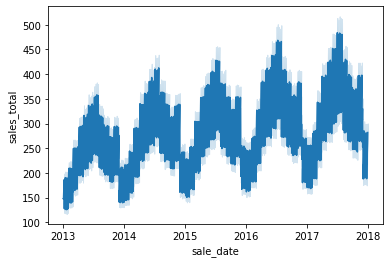

In [24]:
sns.lineplot(x = df.index, y= df.sales_total)

In [63]:
# Human-Based
train = df[:'2016']
test = df['2017']

In [64]:
train.index.min()

Timestamp('2013-01-01 00:00:00+0000', tz='UTC')

In [65]:
test.index.min()

Timestamp('2017-01-01 00:00:00+0000', tz='UTC')

### 2. Validate your splits by plotting X_train and y_train.

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)


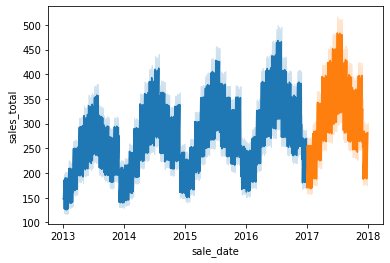

In [66]:
sns.lineplot(x = train.index, y= train.sales_total)
sns.lineplot(x = test.index, y= test.sales_total)

### 3. Plot the weekly average & the 7-day moving average. Compare the 2 plots.

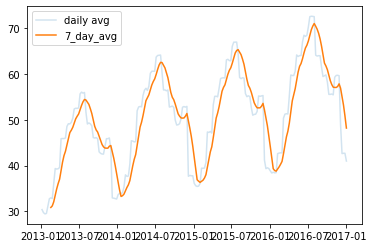

In [77]:
rolling_example = pd.DataFrame()
rolling_example["daily_average"] = train.sale_amount.resample("W").mean()
rolling_example["7_day_avg"] = rolling_example.daily_average.resample("W")
.rolling(7).mean()

plt.plot(rolling_example.index, rolling_example.daily_average, alpha=0.2)
plt.plot(rolling_example.index, rolling_example["7_day_avg"])
plt.legend(['daily avg', '7_day_avg'], loc='upper left')
plt.show()

They are fairly similar - the, rolling average is slightly smoother, and thus easier to detect outliers, or seasons.

### 4. Plot the daily difference. Observe whether usage seems to vary drastically from day to day or has more of a smooth transition.

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


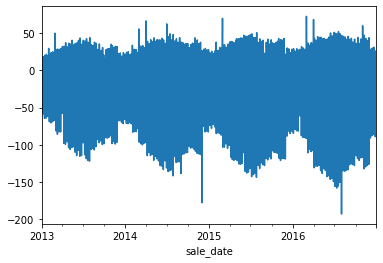

In [83]:
train.sales_total.resample("D").mean().diff(1).plot()

There does seem to be a big number of spikes in the data. I would attribute this perhaps to some outiers, where there was a big discount offer and sales spiked, then reducing back the following period after the promotion ended. There is a lot of variation.

### 5. Plot a time series decomposition.

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


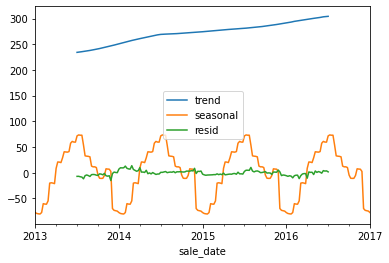

In [87]:
y = train.sales_total.resample("W").mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
        "y": result.observed,
    "trend": result.trend,
    "seasonal": result.seasonal,
    "resid": result.resid,
})

decomposition.iloc[:,1:].plot()

There are several interesting points to take away from this. The first is the fact that there seems to definitively be a positive upwards trends, meaning that total_sales have been increasing over the past years. We also see that there is a seasonality component to sales. In particular, it seems that sales tend to be higher towards the summer months, and then drop towards the end of the year. There is a peak duing October - November time, and this actually could be attributed to Thanksgiving, when customers look to prepare for the holidays.

### 6. Create a lag plot (day over day).

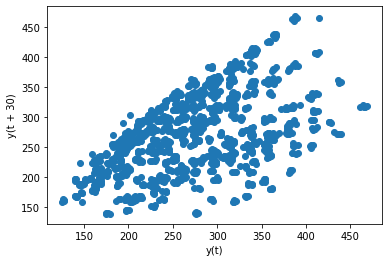

In [90]:
pd.plotting.lag_plot(train.sales_total.resample("D").mean(), lag = 30)

There does seem to be a weird set of linear relationships, where sales seem to have a positive relationship, but it seems to spread out towards the higher sales, and be more narrow towards the lower end of sales.

### 7. Run a lag correlation.

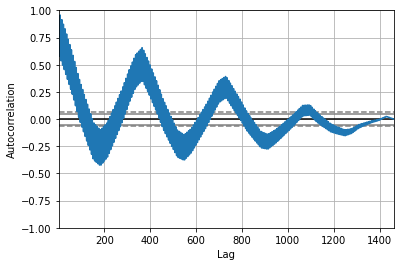

In [91]:
pd.plotting.autocorrelation_plot(train.sales_total.resample("D").mean())

So this graph tells us that there is a seasonality in the data, and with this graph, we can see the frequncy of that seasonality. In this case, because we are looking at daily data, we see that the peaks are around 365 days. This means that the seasonality in the data is actually a yearly seasonality. If it was a quarterly or by annually seasonality, we could see the trends using this graph. 

Important note on the lag graphs. The lag graphs are how the autocorelation graphs are made, and they can help use see things on a more granular scope. This is really helpful, comapre to the seasonal decomposition, because this can help us see the frequency of the seasonality. 

The seasons are only significant when we see peaks that are outside of the confidence bands, meaning that if there are peaks but there are within the confidennce bands, then we can assume that the data doesn't have significant correlations. 

The reason why the plot zero's out towards the end of the data, is because as we approach the "current date", or the most current date, then there are less data points, so it is harder to actually see trends, or correlations, and thus the peaks fall below the confidence intervals. 

----------

## Using your OPS data you prepped in lesson 2 exercises:

### 1. Split your data into train and test using the percent cutoff method.

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/anaconda3/lib/python3.7/site-package

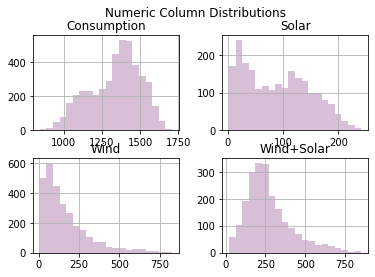

In [93]:
df = prepare.prepped_energy()

In [125]:
df = pd.read_csv("german_energy_csv.csv")

In [126]:
df['Date'] = pd.to_datetime(df['Date'])

In [127]:
df = df.sort_values("Date").set_index(df.Date)

In [128]:
df.drop(columns="Date", inplace=True)

In [129]:
print('Date Range:', df.index.min(), 'to', df.index.max())

Date Range: 2006-01-01 00:00:00 to 2017-12-31 00:00:00


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2006-01-01 to 2017-12-31
Data columns (total 6 columns):
Consumption    4383 non-null float64
Wind           2920 non-null float64
Solar          2188 non-null float64
Wind+Solar     2187 non-null float64
month          4383 non-null int64
year           4383 non-null int64
dtypes: float64(4), int64(2)
memory usage: 239.7 KB


In [149]:
# Percentage-Based
train_size = .75
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:]

### 2. Validate your splits by plotting X_train and y_train.

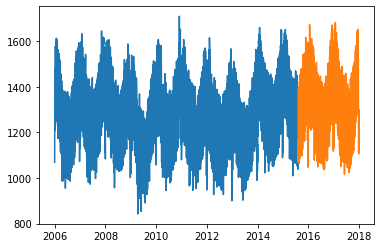

In [147]:
plt.plot(train.index, train.Consumption)
plt.plot(test.index, test.Consumption)

In [151]:
print('Date Range:', test.index.min(), 'to', test.index.max())

Date Range: 2015-01-01 00:00:00 to 2017-12-31 00:00:00


### 3. Plot the weekly average & the 7-day moving average. Compare the 2 plots.

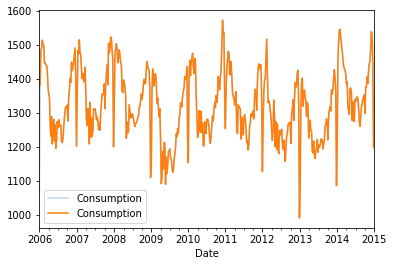

In [268]:
train.Consumption.resample("W").mean().plot.line(alpha=.3)
train.Consumption.rolling(7).mean().plot()
plt.legend()
plt.show()

As we can see, it seems that the weekly average has many more spikes. while the rollowing average is significantly more smooth.

From the graph we can see that there is likely no trend, but there definitively seem to be some seasonality within the years, where energy consumption decreases over the summer months, and incerases on starting in around September thorugh March and April. This makes sense, as you expect citizens of Germany to require more energy during the colder months to power heaters, and then in the summer, because of traiditionally mild summers, for citizens to need less energy.

### 4. Group the electricity consumption time series by month of year, to explore annual seasonality.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

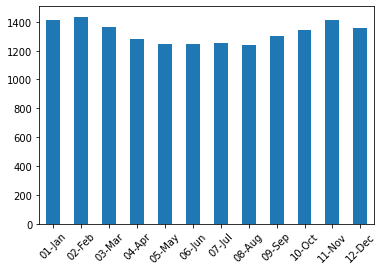

In [168]:
train.groupby(train.index.strftime("%m-%b")).Consumption.mean().plot.bar()
plt.xticks(rotation=45)

As suspected above, we see that energy consumptions peeks during the autum and winter months, and then begin to reduce in the spring and summer. Surprisingly, the mean average is not as significantly different as apparent from the average above.

### 5. Plot the daily difference. Observe whether usage seems to vary drastically from day to day or has more of a smooth transition.

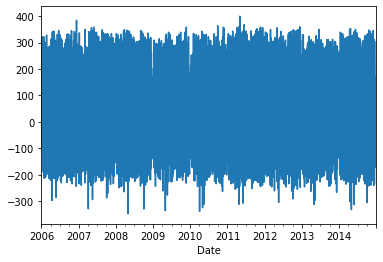

In [177]:
train.Consumption.resample("D").mean().diff().plot()

There seems to be ciertain dates where usage varies drastically, but overall, these seems more like outliers, instead of actual trends.

### 6.  Plot a time series decomposition. Takeaways?

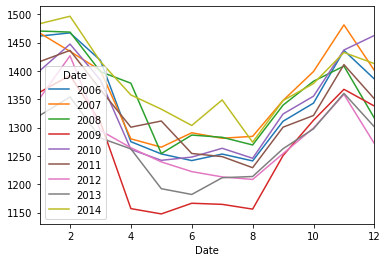

In [176]:
train.groupby([train.index.year, train.index.month]).Consumption.mean().unstack(0).plot()

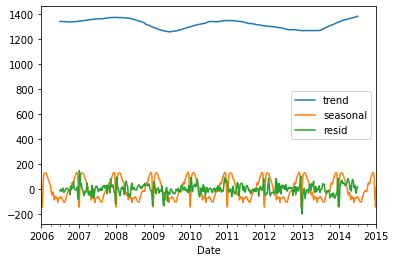

In [174]:

y = train.Consumption.resample("W").mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
        "y": result.observed,
    "trend": result.trend,
    "seasonal": result.seasonal,
    "resid": result.resid,
})

decomposition.iloc[:,1:].plot()


There seems to be a bit of a cyclical correlation in the trend. I suspect that if we plotted this line, alongside temperature in germany over the same time period, we might see that energy consumption increases in colder years, and decreases over warmer years. 

### If time:

For each store I want to see how many items were sold over a period of time, for each item. Find a way to chart this. Hints: Subplots for the piece with the fewest distinct values (like store), x = time, y = count, color = item. If you have too many distinct items, you may need to plot the top n, while aggregating the others into an 'other' bucket.

In [191]:
df = prepare.wrangle_sales_data()

In [259]:
df[store][year][["sale_amount", "item_id"]].nlargest(10, columns="sale_amount")

,sale_amount,item_id
sale_date,,
2017-07-09 00:00:00+00:00,155.0,18
2017-07-16 00:00:00+00:00,155.0,28
2017-07-02 00:00:00+00:00,154.0,15
2017-07-30 00:00:00+00:00,153.0,28
2017-07-22 00:00:00+00:00,150.0,15
2017-07-23 00:00:00+00:00,150.0,38
2017-07-02 00:00:00+00:00,149.0,38
2017-07-08 00:00:00+00:00,146.0,15
2017-07-16 00:00:00+00:00,145.0,18


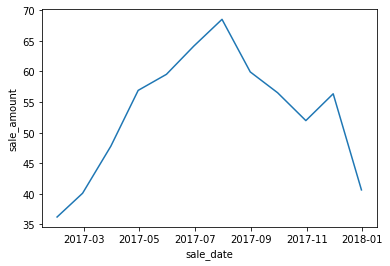

In [251]:
store = df.store == 1
year = "2017"
df_1 = df[store][year].resample("M").mean()

plt.subplots(5,5)
sns.lineplot(data=df_1, y="sale_amount", x=df_1.index)